<a href="https://colab.research.google.com/github/ev1025/DA_Study/blob/main/%EB%8D%B0%EC%9D%B4%ED%84%B0_%ED%95%B8%EB%93%A4%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## T아카데미_정형데이터분석([영상](https://tacademy.skplanet.com/live/player/onlineLectureDetail.action?seq=182))([케글](https://www.kaggle.com/code/envy1025/t-bus-passenger-prediction/edit))

### 데이터분석 순서(요약)

1. 평가지표의 이해
  - 각 평가지표가 중요하게 생각하는 부분을 캐치
2. 데이터의 이해
  - 데이터 사이즈
    - 데이터의 크기
    - 데이터의 밸런스 : train이 test보다 많을경우 과적합을 주의하고, 과적합을 유발할 것 같은 컬럼을 제거하거나 합쳐주고 하이퍼파라미터 조정
   - train,test가 어떻게 분리되어있는가
      - 시계열적으로 분리되어있으면 hold out과 kfold 고려해볼 수 있음
  - 결측치
    -  Boosting모델의경우 결측값이 있어도 잘돌아가므로 Baseline을 잡을때는 크게 신경쓰지 않아도 됨
    - 대신 결측치가 큰 의미를 가진 경우가 있으니 추가적 탐구 필요
  - Target Varience의 분포
    - 정규분포가 좋고, 정규분포가 아닌 경우 어떻게 해결할지 고민
    - 아웃라이어에 대해 이상하게 생각되는 부분은 제거 전 후의 스코어를 비교
    - 한 노선을 A,B,C버스가 운행하는데, 18시\~20시에 C버스의 승객수가 현저히 많은 경우 -> A,B가 18시\~20시 운행을 안해서 일 수 있다. 이런 경우에는 제거하면 안됨(실제 예측데이터에서도 나타날 수 있는 상황이기때문에 예측성능이 많이 저하 될 수 있음)
  - 데이터의 특이한 /주목해야할 부분?
    - station name을 쓸지 code를 쓸지?
    - station name이 같은데 여러번 등장하는 경우?
3. Validation Strategy
 - KFlod, Strategy KFold, Group KFold 일반적으로 사용
 - Hold Out : 시계열 데이터에서 일정 부분이 예측해야할 부분의 분포와 비슷하다고 생각될 때 사용(실제 분포가 비슷하지 않을 경우 성능이 나쁠 수 있음)
4. Baseline모델 만들기
 - 선형모델, 분류모델 모두 사용
 - 선형모델의 coefficient의 절대값이 높은 부분을 보고 중요한 부분 파악
 - 분류모델의 feature importance가 높은 부분을 보고 중요한 컬럼 파악
 - coefficient가 낮은데, feature importance가 높은경우 선형모델에서 학습이 잘 안된 경우이다.
 - 위의 경우 뉴럴네트워크를 이용할 때 Categorical데이터에 대해 Entity Embedding이나 One-Hot encoding을 사용하는 것이 유리
 - PDP Plot을 통해 특정 컬럼에 대한 Target Variable의 변화를 확인할 수 있다.
5. 엔티티를 활용한 피쳐만들기(validation 과정에서 많이 실험해보기)
 - 추가하면 좋을 것 같은 것에 대한 엔티티를 여러개 만들고 피쳐를 하나씩 훈련데이터에 붙여서 성능평가
  - 실제로 좋은 피쳐인데 특정 피쳐와의 잘못된 작용으로 성능을 떨어트리는 것처럼 보일 수 있음 반드시 만들어놓은 피쳐는 기록해두고 많이 섞어서 비교해볼 것
 - validation의 loss가 내려가는지 보는것도 중요하지만, train의 loss와의 차이가 좁혀지는지(과적합이 낮아지는지)도 중요하다.
 - 오래걸리므로 **RunningRate를 높혀서 성능이 좋아지는지 안좋아지는지 여부**만 판단해도 됨

### 1.평가지표 확인

**회귀평가지표**
1. **MAE(MEAN ABSOULTE ERROR)** : 실제값에서 오차만큼의 패널티 부과

2. **RMSE(ROOT MEAN SQUARED ERRROR)** : 실제값에서 오차가 날경우 실제보다 더 크게 패널티를줌

3. **RMLSE(ROOT MEAN SQUARED LOG ERROR)** : 실제값보다 크게 예측하면 적은 패널티, 적게 예측하면 큰 패널티 EX) 전력사용량

**분류평가지표**

1. **ACCURACY**

2. **F1_SCORE**  : 2 * (precision * recal) / (precision+recal)

3. **ROC_AUC_SCORE** : 0.5를 기준으로  TRUE, FALSE 그래프가 분포되는데 구분이 잘될 수록 좋은 모델(0.5가 나쁨, 1이 좋음)
  - TRAIN과 TEST의 타겟변수를 제외한 피쳐로 점수를 계산했을때 
    - 0.5에 가까우면 분포의 차이가 없는 것
    - 1에 가까우면 분포에 차이가 있으니 어떤 컬럼에서 차이가 있는지 확인해야함

### 2. 데이터 이해(분석스킬)

**두 데이터간 존재하는값, 존재하지 않는값 찾기**

In [ ]:
# Train에는 있고, test는 없는 column
train.columns.difference(test.columns) # train.column엔 있고  test.columns엔 없는 colums

# a에는 있고, b에는 없는 값
a.difference(b)

# train['컬럼']과 test['컬럼]의 공통된 값
train_set = set(train['컬럼'])
test_set = set(test['컬럼'])
train_test_common = train_set.interset(test_set)

In [ ]:
# 해당 컬럼의 집계 값 확인
df['컬럼'].agg(['min','max']) 

**misingno(결측값)**


In [ ]:
# 결측값을 표현해주는라이브러리
import missingno as msno
msno.matrix(train)

In [ ]:
# row별로 확인하고 싶으면
train.isnull().sum(axis=1)

**컬럼 이름 리스트로 쉽게 뽑기**

In [ ]:
[col for col in df.columns if '원하는값(_ride)' in col]

**타겟분포 정규화**
- 정규분포가 되는 경우 정규화해서 사용하면 좋음
- 꼭 하지는 않아도 됨

In [ ]:
np.log1p(train['컬럼'])
np.sqrt(train['컬럼'])

**folium(맵으로 보기)**

In [ ]:
# 맵오브젝트
df.itertuples(index=Bool, name='Pandas') # 인덱스 표시, name의 기본값은 Pandas, None으로 하면 일반튜플로바뀜
print(list(df.itertuples()))         # 확인하려면 list로 출력해야함
>>
[Pandas(Index='row1', col1=1, col2=3), Pandas(Index='row2', col1=2, col2=4)]

In [ ]:
import folium 
# from folium import Marker, Icon, CircleMarker

folium.Map(location=[33.35098, 126.79807 ], # 맵 기준 경도,위도
           control_scale=True,    # 컨트롤바 만들지
           zoom_start=10)          # 줌 얼마나 할지

In [ ]:
# 함수로 만들면
def generateMap(default_location=[33.35098, 126.79807], default_zoom_start=10):
    # 지도표시
    base_map = folium.Map(location=default_location, 
                          control_scale=True, 
                          zoom_start=default_zoom_start)
    
    # 여러 개의 정거장에 대해서 Icon 생성하기
    for row in df_sample.itertuples():
        station_code, station_name, latitude, longitude = row[1:]
        
        # Create Icon
        if station_name == '금악리':
            icon = Icon(color='red',icon='station')
        else:
            icon = Icon(color='blue',icon='station')
                
        # Add Marker
        Marker(location=[ latitude , longitude], 
               popup=f'station_code : {station_code} station_name : {station_name}',
               icon = icon).add_to(base_map)
        
    
    base_map.save('하나의 station_name에 여러개의 station_code.html')
    return base_map

generateMap()

### **Validation**

**Hold Out**
- test와 비슷한 분포를 보이는 train의 구간을 val로 설정하여 비교
- 데이터가 충분하지 않은 경우 사용

**K-Fold**
- 보통 대략 5개로 나누며, 어떤 방법이 해당 분석에 맞는지 확인해보고 써야함 
- CrossValidation Score와 실무, 리더보드의 Score가 양의 상관관계를 가져야함(음의 상관관계일 경우 과적합)
- KFold =  unvalence data
- Stratified KFold = invalence data
- Group Fold = 파라미터를 선택해서 그룹화(파라미터로 컬럼 선택)

**Categorical Variable**
- Label-Encoding : 월->0 , 화 ->1 ...
- One-Hot-Encoding : 월 : 0001, 화 0010, 수 0100 ...
- Frequency Encoding(등장횟수) 등등..

In [ ]:
# tqdm(for loop이 얼마나 돌았는지 현재/전체 [소요시간]
from tqdm import tqdm_notebook
f
for i in tqdm_notebook(range(10)):
    print(i)

<ipython-input-10-0436ae395a0b>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(10)):


  0%|          | 0/10 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9


- Mean Encoding
  - Categorical컬럼에 대한 한 컬럼의 평균컬럼을 만드는 것
  - 타겟을 사용하는 것이 아니라서 학습 전에 해도 상관없음

In [ ]:
# Mean Encoding
# dawn_ride : 새벽시간 / date, bus_route_id : 날짜, 정류소번호
# 날짜, 정류장 번호에 대한 dawn_ride의 평균값을 가진 컬럼 생성
# transform('mean') : 각 row에 대한 평균값만 출력

# 탑승
train['avg_dawn_ride_bus_route_id'] = train.groupby(['date','bus_route_id'])['dawn_ride'].transform('mean') 
# 하차
train['avg_dawn_takeoff_bus_route_id'] = train.groupby(['date','bus_route_id'])['dawn_takeoff'].transform('mean') 

- Target-Mean Encoding(타겟의 평균컬럼 생성)
  - Categorical 컬럼에 따른 Target의 평균을 구한 컬럼을 추가하는 것(예시는 밑에 있음)
  - 타겟값을 직접 사용하기 때문에 학습 전에 만들어두면 데이터누수가 발생할 수 있다.(학습 중간에 넣어줘야함)
  - 따라서 KFold에서 K=5이면 4개에 대한 타겟평균을 기반으로 1개의 타겟을 맞추기 때문에 데이터누수를 방지할 수 있다.

**하이퍼파라미터**

In [ ]:
# 모델에 쓰일 parameter
n_splits= 5
NUM_BOOST_ROUND = 100000 # epoch 수
SEED = 1993
lgbm_param = {'objective':'rmse',
              'boosting_type': 'gbdt',  # 가장 많이 쓰임
              'random_state':1993,      
              'seed' : SEED,            # random_state와 같은거
              'learning_rate':0.3,      # 학습률(baseline 만들때는 높게 설정 할 것)
              'subsample':0.7,          # 학습데이터중 몇 %를 사용할 것 인가?(과적합 방지)
              'tree_learner': 'serial', 
              'colsample_bytree':0.78,  # 컬럼 중 몇 %를 사용할 것인가(컬럼이 많은 경우 0.2~0.3)
              'early_stopping_rounds':50, # 50회동안 train의 loss는 감소하고 validation의 loss가 감소하지 않을 경우 중지
              'subsample_freq': 1,
              'reg_lambda':7, # 과적합방지(2~3이 적절, 데이터가 적을 경우 높게)
              'reg_alpha': 5, # 과적합방지(2~3이 적절, 데이터가 적을 경우 높게)
              'num_leaves': 96,

            }

**Out Of Fold**

In [ ]:
# K가 5일때 4개는 train, 1개는 val값으로 훈련했을 때 결과값을 저장할 list
oof_train = np.zeros((train.shape[0],))
oof_val = np.zeros((val.shape[0]))

**KFold 나누고 LightGBM**
- lightGBM은 데이터셋을 따로 만들어줘야함lgbm.Dataset(x,y)
- 예측값과 실제값의 corr가 낮을수록 앙상블에서 성능이 좋음

In [ ]:
# 제거해야하는 columns들 정의
drop_cols = ['id','date', target_col]

# local_train/local_test에 대한 label 정의
local_train_label = local_train[target_col]
local_test_label  = local_test[target_col]

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

# 각 RMSE 저장할 리스트
cv_list = []

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# KFold 나누기
# 인덱스, train인덱스,target인덱스
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = local_train, y = local_train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    # 각 훈련데이터[훈련인덱스] ,타겟데이터[타겟인덱스]
    X_train , y_train = local_train.iloc[trn_ind].drop(drop_cols, 1), local_train_label[trn_ind]
    X_valid , y_valid = local_train.iloc[val_ind].drop(drop_cols, 1), local_train_label[val_ind]
    
    # lightgbm 전용 데이터셋
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , # 하이퍼파라미터
                       dtrain,      # 훈련데이터
                       NUM_BOOST_ROUND, # epoch 수 (보통 만 번)
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), # 표시될이름
                       verbose_eval= 100)             # 학습 100번 당 출력
    
    # local_valid/local_test에 대한 예측
    valid_pred = model.predict(X_valid)
    test_pred  = model.predict( local_test.drop(drop_cols,1) )
    
    # CV를 저장(각 Fold의 RMSE 저장)
    cv_list.append( sqrt( mean_squared_error( y_valid, valid_pred )  ) )
    
    # OOF에 예측값을 저장
    oof_train[val_ind] = valid_pred
    oof_test += test_pred/n_splits
    print('='*80)
    
print(f"<LOCAL_TRAIN> OVERALL RMSE : {sqrt( mean_squared_error( local_train_label, oof_train ) )}")
print(f"<LOCAL_TEST>  OVERALL RMSE : {sqrt( mean_squared_error( local_test_label, oof_test ) )}")

**Train의 loss가 Val의 loss보다 너무 낮으면 과적합, 컬럼이 너무 촘촘하게 세분화 된 경우 합쳐서 사용할 것**

### BaselineModel

**여러가지 모델을 만들어서 결과를 평가한다**
- 두 모델에서 중요하다고 나오는 컬럼이 다를 것이고 그게 왜 그런지 비교
- 선형모델
 - Ridge, Lasso
 - Coefficient가 너무 높거나 너무 낮은경우 주목
 - Coefficeint가 높은 데이터만 가지고 K-Means 분석을 통해 군집화
- 분류모델
 - Decision Tree,  RandomForest, Light GBM
 - Feature Importance가 높은 컬럼 집중
 - XGBoost모델의 경우 카테고리컬 컬럼에 대한 학습 방법이 없어서 Label Encoding보다 One-Hot Encoding이 좋을 수 있음
 - Light GBM은 카테고리컬 정보를 int로 정할지 str로 정할지 선택해야한다.(성능면에서 중요)
 - 하이퍼파라미터로 중요한 카테고리컬럼을 특정하는것이 좋음 (categorical_feature=['컬럼1','컬럼2'])
 - 버스아이디와 같은 컬럼은 CatBoost를 사용하면 더 좋음

- PDP PLOT
  - 모든 변수를 고정하고 하나의 변수의 변화에 따른 예측값의 변화를 확인하는 방법
  - x축 : 변수, y축 : 타겟값
  - 파란색음영이 좁을수록 신뢰도가 높다
  - 신뢰도를 높히려면 샘플값을 늘려야 함


 

**PDP_FLOT**

하나의 변수 변화에 따른 타겟값의 변화(나머지 변수 고정)

In [ ]:
pip install PDPbox

In [ ]:
from pdpbox import pdp

In [ ]:
# pdp_plot에 사용할 데이터(시간이 오래걸려서 일부만 샘플링)
sample = train.drop(drop.cols, 1).sample(1000)

In [ ]:
# 변수 1개를 비교하는 pdp_plot
pdp_ = pdp.pdp_isolate(
    model= model,
    dataset = sample,
    model_fatures = list(sample), # list(데이터) = 컬럼이름만 뽑기
    feature = '컬럼이름', # 확인할 컬럼 이름
)

fg. axes = pdp.pdp_plot(pdp_, '컬럼이름')

2개의 변수 변화에 따른 타겟값의 변화

In [ ]:
pdp_ = pdp.drop_interact(
    model= model, 
    dataset = sample,
    model_features = list(sample),
    features = ['컬럼1', '컬럼2'],
    plot_type='grid'
    x_quantile=True,
    plot_pdp=False
)

### **엔티티를 활용한 피쳐 생성**

**여러가지 엔티티를 만들고 모델에 넣어줄 컬럼을 추가하여 모델링**
- 노선엔티티 : 노선의 종류, 혼잡도, 평균승차인원, 시작과 끝역
- 버스엔티티 : 배차간격, 주요고객 연령층
- 날짜엔티티 : 날씨, 요일, 공휴일**(명절과 한글날을 같은 공휴일로 놓지 말고 평일(0), 한글날(0.5), 명절(1)이런식으로 사용)**

**훈련데이터의 양을 늘리는 방법**
- 스타크래프트 2 승부 예측 데이터
- 교차를 통한 데이터양 늘리기(위아래가 같은 내용이지만 다른 데이터)


|팀1|팀2|맵|A유닛- B유닛|승패|
|--|--|--|--|--|
|A|B|MAP|10|WIN|
B|A|MAP|-10|LOSE

> 기본적인 **인코딩 후** train, validation의 값과    
> 생성한 **피쳐를 추가 후** train, validation의 값을 비교   
> validation의 값이 올라가지 않았더라도 train의 값이 어느정도 맞춰졌다면 과적합을 해소하는 효과가 있는 것

**하이퍼파라미터튜닝**
- 하이퍼파라미터는 초기에는 튜닝하지 않음
- 하이퍼 파라미터 라이브러리 : optuna, hyperopt

**Target-Mean-Encoding을 통한 학습**
- K=5일 때, K(4개)에 대한 타겟의 평균피쳐를 가지고 K(1개)의 타겟을 예측하기 때문에 데이터 누수를 방지할 수 있다.
- Target-Mean-Encoding부분 확인  

In [ ]:
# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # Target- Mean Encoding
    X_train['label'] = y_train # 훈련데이터에 타겟정보를 추가
    d = X_train.groupby(['station_code'])['label'].mean().to_dict() # 노선별 승객 평균수
    X_train['station_code_te'] = X_train['station_code'].apply(lambda x: d.get(x)) # 노선별 평균승객 수 채워주기
    X_valid['station_code_te'] = X_valid['station_code'].apply(lambda x: d.get(x))
    
    X_train= X_train.drop('label',1) # 훈련데이터의 타겟 다시 제거
    
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    print('='*80)
    
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")

**버스정류장 번호가 낮을수록 첫번째 정류장일 것이다**

In [ ]:
# 버스 번호별 정차순서 딕셔너리
bus_route_sequence = {}

# 모든 bus_route_id 수집(버스번호수집)
combined = train.append(test, ignore_index=True)  # train + test
all_bus_route_ids = set(combined['bus_route_id']) # 버스번호 중복제거

for bus_route_id in tqdm_notebook( all_bus_route_ids ) :
    # bus_route_id별 station_code를 오름차순으로 순서매김함
    df_bus_route = combined[combined['bus_route_id']==bus_route_id] # 각 버스번호 데이터만 추출
    sorted_station_codes = np.unique(df_bus_route['station_code'])  # 각 버스번호별 정류장번호를 오름차순으로 뽑기
    
    # dictionary에 해당 정류장이 몇번째 정차 정류장인지 기입
    # {bus_route_id{station_code:inde,}....}
    # {버스번호{정류장번호:순번}...}
    bus_route_sequence[bus_route_id] = {station_code: ind for ind, station_code in enumerate( list(sorted_station_codes) )}

In [ ]:
# 몇 번째 정류장인지를 피쳐로 생성
# get(x[0]) = train['bus_route_id']
# get(x[1]) = train['station_code']
train['nth_station']= train[['bus_route_id','station_code']].apply(lambda x: bus_route_sequence.get(x[0]).get(x[1]), axis=1)
test['nth_station'] = test[['bus_route_id','station_code']].apply(lambda x: bus_route_sequence.get(x[0]).get(x[1]), axis=1)

In [ ]:
# 해당 bus_route_id에는 몇 개의 정류장이 있는지
bus_route_id_total_station_count_dict = combined.groupby('bus_route_id')['station_code'].nunique().to_dict()

train['bus_route_id_total_staion_count'] = train['bus_route_id'].apply(lambda x: bus_route_id_total_station_count_dict.get(x) )
test['bus_route_id_total_staion_count']  = test['bus_route_id'].apply(lambda x: bus_route_id_total_station_count_dict.get(x) )

In [ ]:
# 뒤에서부터 몇 번째 정류정인지 (현재 정류장 - 정류장 수)
train['nth_station_backward']= train['nth_station'] - train['bus_route_id_total_staion_count']
test['nth_station_backward'] = test['nth_station'] - test['bus_route_id_total_staion_count']

**K-Means**
- k값은보통 데이터 row의 수 에 sqrt를 씌워서 사용

In [ ]:
KMeans(n_clusters=int(sqrt(len(df))), random_state=1993)

### Feauter 선택하기
- 각 기술마다 선택되는 Feature가 다르므로 결과를 믿지 말고 본인의 KFold로 검증해볼 것
- SK강의하신분은 TargetPermutation, RFE를 많이쓴다고 하심

**Bouruta 라이브러리**
- Shadow Feature(마구잡이로 섞은 컬럼)을 만든다.
- 기존 Featrue와 Shadow Feature의 FeatureImportance를 비교한다.
- 기존 Feature가 높은 경우를 알아서 분류해줌

**Target Permutation**
- 마구잡이로 섞은 Feature와 기존 Feature의 Feature Importance분포를 비교해서 겹치는 구간이 많은 경우 제거, 겹치지 않을수록 좋은 Feature
- 사용자가 하나의 컬럼씩 따로 비교하고 걸러내야함

**Dropping High Correlation**
- Correlation이 높은 컬럼을 제거하는 방식
- 99이상인 경우 하나씩 제거해보고 평가해서 사용   
ex) 컬럼 A,B,C,D,E중에 A,B,C의 Correlation이 높으면 A,D,E만 사용


**RFE(Recursive Feature Elimination)**
- 최종적으로 사용하길 원하는 Feature의 개수를 지정하면 1개의 Feature씩 제거하면서 성능을 비교해주는 방식

In [ ]:
lgbm_param = {'objective': 'rmse',
             'boosting_type': 'gbdt',
             'random_state': 1993,
             'learning_rate': 0.1,
             'subsample': 0.7,
             'tree_learner': 'serial',
             'colsample_bytree': 0.78,
#              'early_stopping_rounds': 50, RFE에서 문제를 오류를 발생시켜서 제거해야함
             'subsample_freq': 1,
             'reg_lambda': 7,
             'reg_alpha': 5,
             'num_leaves': 96,
             'seed': 1993}

In [ ]:
# REF 사용
from sklearn.feature_selection import RFECV

reg_model = lgbm.LGBMRegressor(**lgbm_param) # 모델. 파라미터
rfe = RFECV(estimator=reg_model, 
            step=1, # 한번의 학습에 몇개의 Feature를 제거할 것인지(높을수록 빠르게 진행)
            cv=KFold(n_splits=5, shuffle=False, random_state=231), scoring='neg_mean_squared_error', verbose=2)
rfe.fit(train.drop(drop_cols,1), train_label)

In [ ]:
# REF 순위 확인
# Feature가 많을 경우 1위인 Feature만 사용(낮을수록 좋은것)
df_rank = pd.DataFrame(data = {'col': list(train.drop(drop_cols,1)) , 'imp': rfe.ranking_})
use_cols = list(df_rank[df_rank['imp']==1]['col'])

### TEST-set값 예측

**Ensemble**
- oof에 예측값을 기록하여 모델별로 가중치를 정해서 예측값 도출

In [ ]:
# RMSE 결과값이 어떤게 좋은지 실험해보고
sqrt(mean_squared_error(target_label, (XGB_PRED * 0.2)+(LGBM_PRED*0.3) + (CAT_PRED\0.5)))

# 좋은 값으로
ensemble_pred = (XGB_PRED * 0.2)+(LGBM_PRED*0.3) + (CAT_PRED\0.5)

**Stacking**
- 각 모델들의 예측값으로 새로운 모델 도출
- Lidge나 Lasso나를 사용(Lasso가 보통 더 많이 사용됨 => 과적합을더 잘잡음)
- Boosting 모델을 사용할거면 reg_lambda나 reg_alpha값을 크게 줘야함


**프로젝트 결과**
- 훈련에 사용할 데이터가 모두 정리된 후 여가지모델을 앙상블하여 결과값도출
- 모델예측값과 실제값의 corr가 낮을수록 앙상블하기 좋음

### **Boosting Model** 사용법

**Bagging**
- 독립적인 모델을 병렬로 이음
- 병렬방식

**Boosting**
- 이전 모델의 오차를 중심으로 단계적으로 학습
- 직렬방식(시간이 느림)

**XGBoost**
- Level Wise 방식으로 같은 계층의 모든 분기가 끝나야 다음 계층으로 넘어감
- categorical vairable을 잘 학습하지못함

**Light GBM**
- Leaf Wise 방식으로 한쪽의 분기가 끝나면 다음 분기 진행
- bin(구간)을 나눠서 학습하므로 연산이 더 빠름
- 하이퍼파라미터를 사용하여 categorical variable의 학습성능을 높힐 수 있음

**CatBoost**
- Categorcal variable이 중요한 경우 성능이 좋음
- Categorical 피쳐 지정해줘야함
- One-Hot Encoding 사용(시간이 많이듬)
- One-Hot Encoding의 범위를 설정해야함

In [ ]:
# CatBoost
n_rounds = 100000
cat_params = {
        'n_estimators': n_rounds,
        'learning_rate': 0.08,   # 오래걸려서 높게 설정하는게 좋음
        'eval_metric': 'RMSE',   
        'loss_function': 'RMSE',
        'random_seed': 42,
        'metric_period': 500,    # 평가주기 
        'od_wait': 500,          # 과적합 방지
        'task_type': 'GPU',      # 무조건 GPU사용
       'l2_leaf_reg' : 3,        # regulation을 얼마나 줄것인지 (2~3이 좋음)
        'depth': 8,              # 깊으면 과적합 (5~10 사이가 좋음)
    }

In [ ]:
# 각 모델에 대한 oof 정의
cat_oof_train = np.zeros((train.shape[0]))
cat_oof_test = np.zeros((test.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)


# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    # Target- Mean Encoding
    X_train['label'] = y_train
    d = X_train.groupby(['station_code'])['label'].mean().to_dict()
    X_train['station_code_te'] = X_train['station_code'].apply(lambda x: d.get(x))
    X_valid['station_code_te'] = X_valid['station_code'].apply(lambda x: d.get(x))
    test['station_code_te'] = test['station_code'].apply(lambda x: d.get(x))
    
    X_train= X_train.drop('label',1)
    
    
    # (5) CATBOOST
    print("---TRAINING CATBOOST---")
    
    # model 정의&학습
    model = CatBoostRegressor(**cat_params)
    
    model.fit( X_train, y_train, eval_set = (X_valid, y_valid), 
              cat_features  = ['bus_route_id','station_code', 'station_code_kmeans'],
              use_best_model=True,
              verbose=True)
    
    # local_valid/local_test에 대한 예측
    cat_valid_pred = model.predict(X_valid)
    cat_test_pred = model.predict(test.drop(drop_cols, 1))
        
    cat_oof_train[val_ind] = cat_valid_pred
    cat_oof_test += cat_test_pred/ n_splits
    print('='*80)
    
print(f"<CATBOOST> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, cat_oof_train ) )}")

## collections 라이브러리

In [ ]:
# 갯수 세기
from collections import Counter
a = ['a','a','a','b','b']
b = '111233'
print(Counter(a))
print(Counter(a)['a'])
print(Counter(b))
print(Counter(b)['3'])

Counter({'a': 3, 'b': 2})
3
Counter({'1': 3, '3': 2, '2': 1})
2


## print

In [ ]:
from pprint import pprint 
ex = [['가','나','다'],['a','b','c'],[1,2,3]]
ex2 = ['가','나','다']

print('--------기본--------')
print(ex)
print(ex2)

--------기본--------
[['가', '나', '다'], ['a', 'b', 'c'], [1, 2, 3]]
['가', '나', '다']


In [ ]:
# *list = [] 한겹 제거
print('-----*list-------')
print(*ex)
print('-------------')
print(*ex2)
print('-------------')
print(*ex, sep='\n')

-----*list-------
['가', '나', '다'] ['a', 'b', 'c'] [1, 2, 3]
-------------
가 나 다
-------------
['가', '나', '다']
['a', 'b', 'c']
[1, 2, 3]


In [ ]:
# sep(사이), end(끝)
print(ex, end='end입니다\n') # default 값이 \n이라서 안써주면 줄넘김 안됨
print(*ex, sep='sep입니다')  # *list와 함께 사용해야함  

[['가', '나', '다'], ['a', 'b', 'c'], [1, 2, 3]]end입니다
['가', '나', '다']sep입니다['a', 'b', 'c']sep입니다[1, 2, 3]


**display**

In [ ]:
# 한번에 표시가능
display(ex)
display(ex2)

[['가', '나', '다'], ['a', 'b', 'c'], [1, 2, 3]]

['가', '나', '다']

## Pandas

### Dataframe(문자열,내장함수 혼재)

In [ ]:
import pandas as pd

df = pd.DataFrame([[1,2],[3,4]],columns = ['컬럼1','컬럼2'],index=['행1','행2'])
df

,컬럼1,컬럼2
행1,1,2
행2,3,4


In [ ]:
# csv파일 불러오기
df = pd.read_csv('url',sep='구분기호', encoding='코드',parse_dates=['date']) # euc-kr
# usecols=['컬럼이름','컬럼이름']  # 일부 컬럼만 불러오기
# skiprows=5 or [1,2,3,4,5]        # 위에서 5열 빼고 불러오기
# nrows = 3                        # 위에서 3열 불러오기
# index_col = '컬럼명' or 컬럼번호 # 해당 컬럼을 인덱스로 사용
# names = ['컬럼1','컬럼2']        # 컬럼이름을 변경
# header = None or 0               # 컬럼명이 없는 자료라면 None 첫번째행을 컬럼명으로 쓸거면 0
# parse_dates = ['컬럼']           # datetime 컬럼 날짜형식으로 받아오기

In [ ]:
# csv파일로 저장
df.to_csv('저장할파일명.csv',index=False)

In [ ]:
# 모든 행과 열 표시
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# 샘플링을 통해 데이터 둘러보기
df['컬럼'].sample(n=,random_state=)            # 행중에 n개의 랜덤샘플 추출
df.sample(frac=0.5, replace=, random_state=)   # frac비율만큼만 랜덤샘플 추출(frac을 1이상으로해서 복원추출가능replace는 무조건True여야함)
df.sample(n=, weight='a', random_state=)       # a열이 큰 값을 기준으로 랜덤추출

In [ ]:
# 행,열 개수
df.shape
df.shape[0]
df.shape[1]

In [ ]:
# 데이터 타입, 이름, 개수 확인
df.info()

In [ ]:
# 결측치 개수 확인
df.isnull().sum()

In [ ]:
# 결측치 제거
df.dropna(axis=, how = all or any)

In [ ]:
# 중복확인
df[df.duplicated(subset=['컬럼1', '컬럼2'])]

In [ ]:
# 중복제거
df.duplicates(subset=['컬럼1', '컬럼2'])

In [ ]:
# 수치형데이터들 평균합계 등 확인
df.describe()

In [ ]:
# 데이터프레임의 카테고리 데이터를 추가하는 방법
# 한 열이 수치형 데이터 일 때, 
df['수치형 컬럼'].describe() # 데이터 범위 확인

bins = [min, 25%, 50%, 75%, max] # 최하~ 최상 구간 수 확인

# 범위에 따라 원하는 레이블명을 입력
labels = ['Low', 'Medium', 'Moderately High', 'High']

#'cut'을 통해 continuous data를 category data로 변경
df['level'] = pd.cut(x=df['수치형 컬럼'], bins=bins, labels=labels)

In [ ]:
# 분위수 구하기 (https://support.minitab.com/ko-kr/minitab/20/help-and-how-to/graphs/boxplot/interpret-the-results/quartiles/)
df.quantile(0.25)  # 일분위 
df.quantile(0.5)   # 이분위
df.quantile(0.75)  # 삼분위
df['컬럼1'].quantile(0.75) -df['컬럼1'].quantile(0.25) # 사분위 3-1분위 구간

In [ ]:
# 수치형 데이터 걸러내기
df.select_dtypes(include='object') # 범주형 데이터만 추출(object)
df.select_dtypes(exclude='object') # 수치형 데이터만 추출

,컬럼1,컬럼2
열1,1,2
열2,3,4


In [ ]:
# 유일값
df.컬럼1.unique()

array([1, 3])

In [ ]:
# 유일값 개수
df.컬럼1.nunique()

2

In [ ]:
# 컬럼, 인덱스 목록
df.columns
df.index

In [ ]:
# 컬럼,인덱스명 바꾸기
df.columns = ['이름1', '이름2']  # 모든 컬럼 다 바꿀 때
df.index = ['이름1', '이름2']  # 모든 컬럼 다 바꿀 때

df.rename(columns = {'옛이름1':'새이름1', '옛이름2':'새이름2'},inplace=True)
df.rename(index = {'옛이름1':'새이름1', '옛이름2':'새이름2'},inplace=True)

df.rename(columns = lambda x: "접두사" + x, inplace = True)

df.reindex('이름1','이름2') # 인덱스이름 지정(값이 없는인덱스는 Nan으로 채움)

In [ ]:
# 컬럼 순서 변경
df = df['col2', 'col3', 'col1']

In [ ]:
# loc iloc
df.iloc[0,0]
df.loc['행1','컬럼1']

df.iloc[lambda x: x.index % 2 == 0]
df.loc[df['컬럼1']>1]

,컬럼1,컬럼2
행2,3,4


In [ ]:
# 컬럼 제거
df.drop(['컬럼1','컬럼2'], axis =)

# df = df.drop(index = df[df["columns"] >= 25].index) #인덱스 25보다 큰값 제거

In [ ]:
# 열 추가(df에 컬럼3을 추가)
df.assign(컬럼3 = lambda x: x.col1+2)

In [ ]:
# 컬럼의 문자열 일부 가져오기
df['email_get']  = df['email'].str.get(i=0)    # email컬럼의 첫 글자 가져오기
df['email_slice'] = df['email'].str.slice(start=0, stop=5) # email컬럼의 0~5번째 문자 가져오기

# 인덱스 사이 값을 다른 값으로 바꾼 후 값 반환
df['email_slice_replace'] = df['email'].str.slice_replace(start=0, stop=5, repl='?')

In [ ]:
# 멀티인덱스 제거
df1.columns.get_level_values(n)      # n번째 인덱스 확인 방법 
df.columns = df.columns.droplevel(n) # n번째 인덱스 제거

# 멀티인덱스 제거 (멀티인덱스를 / 로 나눠서 단일 컬럼화)
table.columns = ['/'.join(col) for col in table.columns]

In [ ]:
# 멀티인덱스 정렬 (mean의 수학의 문과열)
table.sort_values(('mean', '수학', '문과'), ascending = False)

In [ ]:
# 데이터프레임에 포함한 글자있는 행
df= df[df.columns.str.contains('포함될 글자')]

# 포함하지 않는 행
df= df[~df.columns.str.contains('포함될 글자')]

# 포함하지 않는 행 value에러 발생 시(dtype이 섞여있을 때 발생)
new_df = df[df["col"].str.contains(word) == False]
new_df = df[~df["col"].str.contains(word, na=False)]

In [ ]:
df.to_dict()

**split**

In [ ]:
# str.split('기준문자', 나눌 횟수)
text = 'Hello, world, python'
strings = text.split(',', 1) # -1은 제한없음을 의미(default)
print(strings)

['Hello', ' world, python']


In [ ]:
# 데이터프레임 str.split('',expand=True)
df_data = pd.DataFrame(['2018-10-11', '2018-10-12'],columns=['data'])

# 리스트로 만들기
df_data_1 = df_data['data'].str.split('-')
print(df_data_1)
print('-----------------------------------')

# 데이터프레임에 넣어주기
df_data[['연','월','일']]= df_data['data'].str.split('-', expand=True)
df_data

0    [2018, 10, 11]
1    [2018, 10, 12]
Name: data, dtype: object
-----------------------------------


,data,연,월,일
0,2018-10-11,2018,10,11
1,2018-10-12,2018,10,12


In [ ]:
# 함수를 iterator에 적용(순서대로)
from functools import reduce
# reduce(함수, iterator) 
print(df)
print('---------')
reduce(lambda x,y : x+y, [df['컬럼1'],df['컬럼2']]) # 컬럼값 합치기

    컬럼1  컬럼2
행1    1    2
행2    3    4
---------


행1    3
행2    7
dtype: int64

**query**

In [ ]:
# 쿼리
df1 = df.query(' 자치구 != ("서울시", "시설관리공단", "공원녹지사업소" ) ' )

df.query('컬럼1 == 0' and '컬럼2==3')
df[(df['컬럼1']==0) & (df['컬럼2']==3)] # and, or 안됨

# df[df['컬럼1'].insull() | df['컬럼2].insull() | df['컬럼3].isnull()]

excepts = df[df['자치구'].str.contains('서울시|공원녹지사업소|시설관리공단')].index
df.drop(excepts, inplace=True)

exclude = ['서울시', '공원녹지사업소', '시설관리공단']
df_sub = df.query("자치구 not in @exclude").copy()


# 자치구가 abc에 해당하는 데이터 뽑기
abc = ['도봉구','노원구','강북구']
df_sub = df[df['자치구'].isin(abc)]

# 날짜가 2022.01.01인 정보만 뽑기
df[df['date']==datetime(2022,01,01)]


test = ["old_page" if i == "control" else "new_page" for i in ab_data.그룹]
# control 그룹 중 new page를 본 유저와 experiemnt 그룹 중 old page를 본 유저들을 확인 
error_data = ab_data[test != ab_data["랜딩페이지"]]
ab_data.drop(error_data.index)
     

In [ ]:
# 그룹바이(유저번호로 묶어서 누적주문,주문시간의 합을 출력)
df.groupby('유저번호')['누적주문','주문시간'].sum()
df.groupby(['quality','color']).sum() # 왼쪽(quality가 묶임)
df.groupby(['quality','color'], as_index = False).sum() # 오른쪽, 인덱싱 여부를 결정

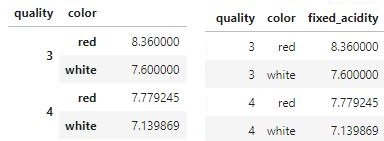

**groupby**

In [ ]:
# Series형식 추출
df.groupby('컬럼')['컬럼']

# DataFrame형식 추출
df.groupby('컬럼')[['컬럼']]

# 각 row의 값만 보고 싶을 때
df.groupby(['컬럼1','컬럼2'])['컬럼3'].mean() # 컬럼1, 컬럼2에 대한 컬럼3의 평균
df.groupby(['컬럼1','컬럼2'])['컬럼3'].tarnsform('mean') # 각 row별 컬럼3의 평균값만 추출

In [ ]:
# 컬럼별 개수 (=value_counts)
df.groupby('컬럼').size()

In [ ]:
# 데이터 일치 여부를 bool로 출력
# Series : index의 값이 일치 = True
# Dataframe : index와 columns의 값이 일치 = True
# Dict = Key(columns)의 value값이 일치 = True

df.isin(values) # values에 시리즈,데이터프레임,딕셔너리 넣으면 됨
df.isin([1,3])  # list를 넣으면 해당 인자값이 있는 곳에 True 반환

df[df.index.isin(is_null.index)] # null값만 모은 데이터의 인덱스를 가져와서 null데이터만 출력

**padding**

In [ ]:
# 왼쪽으로 채울글자를 n만큼 채워줌
str.pad(n, fillchar='채울글자')

In [ ]:
# zfill(숫자) 왼쪽으로 0을 채워줌, 마이너스를 맨 왼쪽으로 이동
print('38'.zfill(5))
print('-38'.zfill(5))

00038
-0038


In [ ]:
# rjust, ljust, 왼쪽 오른쪽 선택해서 원하는 글자를 채워줌, 마이너스위치그대로
print('38'.rjust(5,'a'))
print('-38'.rjust(5,'a'))

aaa38
aa-38


**strip**

In [ ]:
# strip() 문자열의 공백이나 매개변수를 제거
# lstrip() 왼쪽만 제거, rstrip() 오른쪽 제거

str1 = "****Welcome to Entity05****" # 양쪽 제거
after_strip = str1.strip("*")
print(after_strip)

str2 = "Welcome to Entity05"        
after_strip1 = str2.strip("05")
print(after_strip1)

str3 = "Welcome to Entity05"         # 문장 중간의 값인 to는 제거하지 않음
after_strip3 = str3.strip("to")
print(after_strip3)

Welcome to Entity05
Welcome to Entity
Welcome to Entity05


**정렬**

In [ ]:
# 값의 개수(False), 비율(True)
df.value_counts(normalize=False, ascending=True)

컬럼1  컬럼2
1    2      1
3    4      1
dtype: int64

In [ ]:
# by순서로 정렬
df.sort_values(by=['컬럼1','컬럼2'])

In [ ]:
# 인덱스를 숫자로 초기화 시키고 column에 추가
df.reset_index(drop=True)

In [ ]:
# 컬럼1을 인덱스로 
df.set_index('컬럼1',inplace=True)

In [ ]:
# 순서 지정 정렬
# 내가 원하는 순서대로 정렬하도록 바꾸는 법
yoil_dict = {'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6}

group_day['yoil'] = sorted(group_day['yoil'], key=lambda x : yoil_dict[x])

In [ ]:
# 인덱스 순서 지정
df.reindex(['월','화','수','목','금','토','일'])

**피벗 테이블**

In [ ]:
df.pivot_table(index='', columns='', values='개수값', aggfunc=lambda x: len(x)/1000).fillna(0) # aggfunc는 값에 적용해줄 함수

#### **데이터합치기**

In [ ]:
import pandas as pd
df_sum1 = pd.DataFrame({'a':['a0','a1','a2','a3'],
                   'b':['b0','b1','b2','b3'],
                   'c':['c0','c1','c2','c3']},
                  index = [0,1,2,3])

df_sum2 = pd.DataFrame({'a':['a2','a3','a4','a5'],
                   'b':['b2','b3','b4','b5'],
                   'c':['c2','c3','c4','c5'],
                   'd':['d2','d3','d4','d5']},
                   index = [2,3,4,5])

##### 컬럼 합치기

In [ ]:
def combine_2rd_columns(col_1, col_2):
    result = col_1
    if not pd.isna(col_2):
        result += " " + str(col_2)
    return result

df["result"] = df.apply(lambda x: combine_2rd_columns(x['col_1'], x['col_2']), axis=1)

##### 컬럼에 값 넣기

In [ ]:
# df1에 새로운 컬럼 col3를 만들 때, col3를 co1별 col2의 개수로 채우고 싶으면

# col1을 인덱스로 놓는다. 
df1.set_index('col1',inplace=True)

# col1를 기준으로 col2의 종류 개수를 담은 시리즈를 만든다
Series_data = df1.groupby('col1').nunique()['col2']

# 위에서 만든 시리즈를 col3에 넣는다.
df1['col3'] = month_num

# 인덱스를 되돌린다.
df1.reset_index(inplace=True)

In [ ]:
# 리스트를 컬럼에 넣고 싶을 때
# 컬럼의 행개수와 리스트의 인자 개수가 같으면 바로 입력됨
df['col'] = list_data

##### **concat**

In [ ]:
df_concat0 = pd.concat([df_sum1,df_sum2], axis=0)
df_concat0

,a,b,c,d
0,a0,b0,c0,NaN
1,a1,b1,c1,NaN
2,a2,b2,c2,NaN
3,a3,b3,c3,NaN
2,a2,b2,c2,d2
3,a3,b3,c3,d3
4,a4,b4,c4,d4
5,a5,b5,c5,d5


In [ ]:
df_concat2 = pd.concat([df_sum1,df_sum2], axis=1)
df_concat2

,a,b,c,a,b,c,d
0,a0,b0,c0,NaN,NaN,NaN,NaN
1,a1,b1,c1,NaN,NaN,NaN,NaN
2,a2,b2,c2,a2,b2,c2,d2
3,a3,b3,c3,a3,b3,c3,d3
4,NaN,NaN,NaN,a4,b4,c4,d4
5,NaN,NaN,NaN,a5,b5,c5,d5


In [ ]:
# concat axis=0과 같은 방법
df_concat1 = df_sum1.append(df_sum2, ignore_index=True)

##### **merge**

In [ ]:
# 데이터 합치기
'''
left : df1를 기준으로 df2에 Nan 표시
right : df2를 기준으로 df1에 Nan 표시
inner : 교집합만 표시 (기본값)
outer : 모든 값 표시
'''
pd.merge(df1,df2, how='inner',on='기준컬럼')

In [ ]:
df_merge = pd.merge(df_sum1, df_sum2, how='outer')
df_merge

,a,b,c,d
0,a0,b0,c0,NaN
1,a1,b1,c1,NaN
2,a2,b2,c2,d2
3,a3,b3,c3,d3
4,a4,b4,c4,d4
5,a5,b5,c5,d5


In [ ]:
# merge 여러개 => 요런식 ((df1 +df2) +df3)+df4)
from functools import reduce
data = [df1,df2,df3]
reduce(lambda x,y : pd.merge(x,y), data)

##### **join**

In [ ]:
df_join = df_sum1.join(df_sum2, how='right', lsuffix='1', rsuffix='2')
df_join

,a1,b1,c1,a2,b2,c2,d
2,a2,b2,c2,a2,b2,c2,d2
3,a3,b3,c3,a3,b3,c3,d3
4,NaN,NaN,NaN,a4,b4,c4,d4
5,NaN,NaN,NaN,a5,b5,c5,d5


In [ ]:
# List -> 문자열로 합치기
df_abc = ['a','b','c']

print(''.join(df_abc))
print('_'.join(df_abc))
print("띄고\n".join(df_abc))

abc
a_b_c
a띄고
b띄고
c


##### **melt**

In [ ]:
# pd.melt(데이터, 
#         id_vars=['열1','열2'],     # 기준이 될 열
#         value_vars=['열3','열4'],  # 값으로 넘어갈 열
#         var_name = '열제목',       # 값으로 넘어간 열의 열제목이 들어가는 컬럼 제목
#         value_name = '값제목')     # 값으로 넘어간 열의 값들의 제목

df_melt = pd.DataFrame({'나이':['41','42','43','44'],
                       '성별':['남','남','여','여'],
                       '스타':[1,2,3,4],
                       'YG':['아이유','BTS','현빈','손예진'],
                       'SM':['장동건','고소영','이나영','원빈']})
df_melt # 밑에 결과값 참고

,나이,성별,스타,YG,SM
0,41,남,1,아이유,장동건
1,42,남,2,BTS,고소영
2,43,여,3,현빈,이나영
3,44,여,4,손예진,원빈


In [ ]:
df_melt = pd.melt(df_melt,
                  id_vars = ['나이','성별','스타'],
                  value_vars = ['YG','SM'],
                  var_name = '소속사', # 기존열 이름
                  value_name='이름')   # 기존값 이름
df_melt

,나이,성별,스타,소속사,이름
0,41,남,1,YG,아이유
1,42,남,2,YG,BTS
2,43,여,3,YG,현빈
3,44,여,4,YG,손예진
4,41,남,1,SM,장동건
5,42,남,2,SM,고소영
6,43,여,3,SM,이나영
7,44,여,4,SM,원빈


### Serise

In [ ]:
Sr_1 = pd.Series([1,2],index=['행1','행2'])
Sr_1

행1    1
행2    2
dtype: int64

In [ ]:
# Series to DateFrame
Sr_2 = Sr_1.to_frame('열1')
Sr_2

,열1
행1,1
행2,2


In [ ]:
Sr_1.index

Index(['열1', '열2'], dtype='object')

In [ ]:
Sr_1.index.values

array(['열1', '열2'], dtype=object)

In [ ]:
list(Sr_1.index.values)

['열1', '열2']

In [ ]:
Sr_1.values

array([1, 2])

In [ ]:
# 멀티 인덱스 Series를 Data프레임으로 바꾸는 법
# 두번째 인덱스를 columns으로 바꿈
Sr_4 = Sr_1.unstack()

### Dict

In [ ]:
# dict 합치기
dict3 = dict(dict1,**dict2)

## Datetime

**strftime** : datetime형식을 문자열 형식으로

**strptime** : 문자열형식의 날짜를 datetime형식으로

**공식문서**: https://docs.python.org/ko/3/library/datetime.html#strftime-strptime-behavior

**Pandas**   
https://mindscale.kr/course/pandas-basic/datetime/   
https://durian9s-coding-tree.tistory.com/8

In [ ]:
from datetime import datetime

In [ ]:
# str to datetime
# datetime.strptime(str형식, '%Y-%m-%d')
ex_str = '2023-01-24'
ex_date = datetime.strptime(ex_str, '%Y-%m-%d') # 날짜형식
ex_date

datetime.datetime(2023, 1, 24, 0, 0)

In [ ]:
# datetime to str
# 날짜데이터.strftime('%Y-%m-%d %H:%M:%S')
ex_date.strftime('%Y-%m-%d %H:%M:%S') # 연월일 시분초

'2023-01-24 00:00:00'

In [ ]:
# 요일 정보 (0~6 == 월~일)
# 날짜데이터.weekday()
ex_date.weekday()

1

In [ ]:
# datetime컬럼의 일부만 빼오기
df['날짜컬럼'] = df['날짜컬럼'].dt.year    # 연도 정보
df['날짜컬럼'] = df['날짜컬럼'].dt.month   # 월 정보
df['날짜컬럼'] = df['날짜컬럼'].dt.day     # 일 정보
df['날짜컬럼'] = df['날짜컬럼'].dt.dayofweek # 요일정보
df['날짜컬럼'] = df['날짜컬럼'].dt.weekofyear # 주차정보
df['날짜컬럼'] = df['날짜컬럼'].dt.hour    # 시간 정보
df['날짜컬럼'] = df['날짜컬럼'].dt.minute  # 분 정보
df['날짜컬럼'] = df['날짜컬럼'].dt.second  # 초 정보
df['날짜컬럼'] = df['날짜컬럼'].dt.strftime('%Y-%m') # 년-월 정보 빼오기

In [ ]:
%A # 요일 영어로
%B # 월 영어로

%Y # 연도
%m # 월
%d # 일

%H # 시간
%M # 분
%S # 초

%I:%M:%S %p # pm 시간

더많은 dt 공식문서 : https://pandas.pydata.org/pandas-docs/stable/reference/series.html#datetimelike-properties

In [ ]:
# columns -> datetime
# 컬럼에 str형식의 날짜데이터 있을때 datetime형식으로 바꾸기
df['col'] = pd.to_datetime(df['col'], format='%Y-%m-%d %H:%M:%S' )

In [ ]:
# 기간 구하기 (시작날 - 끝날)
diff = ex_date - pd.to_datetime('2020-02-12 15:39')
print(diff)      # 시간까지
print(diff.days) # 일자만

1076 days 08:21:00
1076


In [ ]:
# 날짜로부터 days일 뒤는 몇일?
ex_date + pd.Timedelta(days=15)
# 전날 
ex_date - pd.Timedelta('1 day')

datetime.datetime(2023, 2, 8, 0, 0)

In [ ]:
# 날짜를 요일로 바꾸기
from datetime import datetime

# str => 요일(0(월요일)~6(일요일))
ex_str = '2023-01-31'
a = datetime.strptime(ex_str, '%Y-%m-%d').weekday()
print(a)


# 요일 딕셔너리 지정하면 바로 출력
dict_week = {0:'월',1:'화',2:'수',3:'목',4:'금', 5:'토',6:'일'}
dict_week[a]+'요일'


## 컬럼전체 변경
## 오래걸리고 비효율적, 요일은 한글보다 숫자로 두는게 나은 듯 하다.
## 한글로 변경하면 그래프에서 정렬이 이상하게된다.
# for i in range(len(df2)):
#     df2.loc[i,'yoil'] = dict_week[datetime.strptime(df2.loc[i, 'date'], '%Y-%m-%d').weekday()]

1


'화요일'

## Numpy

In [ ]:
# 반복함수
np.repeat('A',5) # A를 5개 가진 배열 생성

In [ ]:
# 시작, 끝점을 num개로 나눈 1차원 배열(끝점을 포함, 간격표시하지않음)
np.linspace(start, stop, num, endpoint=True, retstep=False)

In [ ]:
# np.where(조건, 참값,거짓값)
import numpy as np

a = np.arange(5, 15) # array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

# 1차원 데이터
print(np.where(a > 10)) # 만족하는 인덱스 출력 -> (array([6, 7, 8, 9]),)
print(np.where(a > 10, True, False)) # 만족하는 값은 True로 아닌값은 False로

(array([6, 7, 8, 9]),)
[False False False False False False  True  True  True  True]


In [ ]:
# 2차원데이터 (axis가 (0,0), (0,2),(1,0)인 값의 인덱스를 나타내는 것) 
b = np.array([[15, 8, 12], [11, 7, 3]])
np.where(b > 10) # (array([0, 0, 1]),  => axis=0의 인덱스
                 #  array([0, 2, 0]))  => axis=1의 인덱스

(array([0, 0, 1]), array([0, 2, 0]))

In [ ]:
# 샘플뽑기
np.random.seed(1)
np.random.choice(모집단, 샘플사이즈, replace=True)
np.random.beta()

# 샘플뽑기 다른방법
pop.sample(n=3, random_state=2, replace=True)

## 그래프

- boxplot : 데이터의 사분위수, 최소값,최대값, 이상치 확인 (수치형 데이터)

- barplot : 데이터를 비교하는데 유용한 시각화, 데이터빈도, 비율 (범주형데이터)

- scatterplot : 두 변수간 관계를 확인 (수치형 - 수치형)

In [ ]:
# 한글 그래프 폰트(plt.rc('font', family='NanumBarunGothic'))
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
# rc는 한 번만 적용하면 모든 그래프에 적용된다는 장점이자 단점이 있다.
plt.rc('font', family ='글꼴') 
plt.rc("font", family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False) # 한글로 바꾸면 마이너스표시가 안뜰때 처리방법
plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('xtick', labelsize=50)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=50) # figure title 폰트 크기
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

In [ ]:
# plt 그래프 화질조정1
%config InlineBackend.figure_format='retina'

# plt 그래프 화질조정2
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [ ]:
# x축은 시간, y축은 요일 이런식의 피벗테이블에서 사용가능
plt.figure(figsize=(20,10))

data = df.pivot_table(index='', columns='', values='개수값', aggfunc=lambda x: len(x)/1000).fillna(0) # aggfunc는 값에 적용해줄 함수

sns.heatmap(data, annot=True, linewidths=0.5, fmt = '.2f', cmap='YlGnBu')
plt.yticks(len(range(df.index)), df.index, rotation='horizontal')
plt.ylabel('요일',rotation='horizontal', labelpad=30, fontsize=20)
plt.xlabel('주문시간', labelpad=15, fontsize=20)
# 히트맵 y축 맞추기
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

# 수평선
# 축에 맞춰서 
plt.axhline(y축, 시작, 끝, color='lightgray', linestyle='--', linewidth=3)
plt.hlines(-0.62, 1.0, 2.5, color='gray', linestyle='solid', linewidth=3)

# 수직선
plt.axvline(y축, 시작, 끝, color='lightgray', linestyle='--', linewidth=3)
plt.vlines(-0.62, 1.0, 2.5, color='gray', linestyle='solid', linewidth=3)

plt.title('요일별 주문 시간',pad=20)

plt.show();

In [ ]:
# 그래프 .plot
df.plot(kind='bar', 
        title='Average Wine Quality by Color',
        fontsize=13, 
        color=['red', 'blue'],
        alpha=0.4);                           

In [ ]:
# plt.scatter(index없이 column이름만 있는 데이터에서 사용)
plt.scatter(x, y, 
            alpha = 0~1,  # 투명도
            s = z         # 마커의 크기 (x가 요일 y가 시간이면 z는 판매량)
            c = z         # 마커의 색상
            cmap='blues' or 'rainbow' or 'viridis'
            vmin=0, vmax=최대길이) # 컬러바 범위 조절

plt.gca().invert_yaxis() # y축 오름차순
plt.colorbar()       # 오른쪽에 범위 바 생성
plt.clim(0,최대길이) # vmin vmax와 동일

23번문제부터

## 내장함수

**zip**

In [ ]:
# 같은 크기의 리스트를 묶어주는 함수(여러개도 묶을 수 있음 zip(a,b,c,d))
# 크기가 모자한 것은 제거(a = 5개고 a[1:]는 4개니까 4개만 출력되는 것을 볼 수 있음)
a=[1,3,2,5,4]
for p1, p2 in zip(a,a[1:]):
	print(p1, p2)

1 3
3 2
2 5
5 4


**append, extend**

In [ ]:
# append - 데이터 형태를 보존하여 삽입
# extend - 데이터 형태를 보존하지 않고 인자별로 삽입
list1 = [1,2,3]
list2 = {4,5,6}
lsit3 = 7,8,9

list1.append(list2)
print(f'append : {list1}')

list1.extend(lsit3)
print(f'extend : {list1}')

append : [1, 2, 3, {4, 5, 6}]
extend : [1, 2, 3, {4, 5, 6}, 7, 8, 9]


In [ ]:
# 데이터프레임에서 concat과 같은 방법
df1.append(df2, ignore_index=True)
df1.concat(df2)

[1, 2, 3, [4, 5, 6], 4, 5, 6, 4, 5, 6]

In [ ]:
# .agg : 함수적용
df.agg({'price': np.mean, 'quantity': np.sum}) # price컬럼에 평균, quantity컬럼에 합계 적용

In [ ]:
# apply: 함수적용
df.apply(함수, axis=0) # column별 함수적용(default)
df.apply(함수, axis=1) # rows별 함수적용

# df['abc']의 값을 key로 사용하여 d의 value를 받아오는 것
# 결국 abc['abc']의 평균값을 df['abc']에 맞게 df['새컬럼']에 넣어주는것
d = abc['abc'].mean()
df['새컬럼'] = df['abc'].apply(lambda x : d.get(x), axis=1)

In [ ]:
# key값과 완전 일치하는 것만 변경
df.replace({'male':'남', 'female':'여'})
df.replace( ['male','female'], [0, 1])  # male -> 0 / female -> 1 한 번에 변형

# 포함된 값 모두 변경 (str의 의미는 Series 전체에 적용됨을 의미)
df.str.replace('a','b')         # a가 포함된 것들 모두 b로 바꿈
df.str.replace('[_!.\d+]', '')  # []안의 문자 모두 ''로 바꿈
df.str.replace(r'[^a-zA-Z]', '', regex=True)

In [ ]:
# 정규표현식이 포함된 값 가져오기
df.str.extract('(\d+)')

In [ ]:
# 포함된 값 bool형태로 불러오기
df.str.contains(' ',na=True)  #  Nan값을 치환하려면 na=bool값

In [ ]:
# 각 데이터 접두사, 접미사 추가
df['col'] = df['col'].astype('str') + '접미사'
df['col'] = '접두사' + df['col'].astype('str')

In [ ]:
# Bool형식의 데이터 뒤에 넣어주면 0, 1로 출력가능(메모리 측면에서 좋음)
.astype(np.int8)

In [ ]:
# loc 사용 예시

# 잘못된 예
for i in range(len(df)):
    df['col'][i] = df['col'][i].strftime('%m')

# 좋은 예
for i in range(len(df)):
    df.loc[i,'col'] = df.loc[i,'col'].strftime('%m')

## 정규표현식

In [ ]:
# 데이터프레임의 전화번호 정리하기
import re

def convert(phone_number):
  phone_number = re.sub(r"\D", "", phone_number)[-8:]
  final_number = '010' + '-' + phone_number[:4] + '-' + phone_number[-4:]
  return final_number

df.전화번호 = df.전화번호.apply(convert)

## For문 

In [ ]:
# df.shape이 (n,k)일 때
# df행별로 값을 묶어줄 때
records=[]
for i in range(len(df)): # len(df) = n
    records.append([df.values[i,j] for j in range(len(df.columns))]) # len(df.columns) = k

## 분류모델

#### 연관성분석(association rule)

In [ ]:
# 1. 데이터프레임을 이중리스트로 만들기
# 주문번호 별 주문 리스트 나누기(한 번 주문 할 때 어떤 물건을 같이 사는지 확인하기 위해서)

# 연관규칙분석을 위해 요소 비교를 하는 과정에서 시간이 오래걸려서 리스트 대신 array를 사용하였다.
# 하나의 iterator 요소간 비교에서 zip 함수를 사용 할 수 있었다.
# 마지막 열은 record에 append 되지 않는 점을 확인하여 if문을 하나 더 추가하여 마지막 열 추가

df_array = df.values # 전체 데이터를 array화 하여 계산속도 증가

record = [] # 주문번호 별 주문내역리스트
record2 =[] # 한 주문에 포함 된 내역

for p1, p2 in zip(df_array, df_array[1:]): # 0과1 1과2 ... 비교하도록 for문 

    if p1[0]==p2[0]:              # 주문번호가 같으면 record2에 추가
        record2.append(p1[2])

        if p1[2]==df_array[-2][2]: # 전체데이터의 마지막열에 도달하면 마지막 주문내역 record에 추가
            record2.append(p2[2])
            record.append(record2)
  
    else:
        record2.append(p1[2])    # 주문번호가 다르면 해당 주문의 마지막 물건이다. 주문번호 마지막 목록을 record2에 추가하고
        record.append(record2)   # 해당 주문을 그룹화한 record2를 record에 추가하고
        record2 = []             # record2를 초기화

**surpport (지지도)**
- $P(A∩B)$ 
- A,B가 동시에 일어난 수 / 전체 거래 수
- A와 B가 동시에 거래되는 비중 

**confidence (신뢰도)**
- $P(A∩B)/P(A)$
- A,B가 동시에 일어난 수 / A가 일어난 수
- A를 포함하는 거래 중 A,B가 동시에 거래되는 비중

**lift(향상도)**
- $P(A∩B) / P(A)*P(B)$  = $P(B|A) / P(B)$
- A,B가 동시에 일어난 수 / 독립된 A * 독립된 B
- AB, AC가 같은 신뢰도를 가질 때, B와 C 중 어느것이 더 관련있는지
- (lift = 1) 독립 / (lift > 1) 양의 상관관계 / (lift < 1) 음의 상관관계  

> **Tip**   
1. 지지도,신뢰도, 향상도가 모두 높다 = 좋은 rule
2. 지지도가 낮고 신뢰와 향상도가 높다 = 실효성이 떨어짐

##### **apriori공식문서** : http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/

In [ ]:
# 2. 이중리스트로 만든 df를 원핫인코딩 형태로 바꿔줌(컬렴명 = 제품명, 값 = 0이나 1 값)
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(record).transform(record) # fit = 고유한 라벨을 갖게됨 / transform = 원핫인코딩,numpy배열로 전환
ap_data = pd.DataFrame(te_ary,columns=te.columns_) # 원핫 인코딩 된 데이터프레임으로 변환

In [ ]:
# 3-1. 원하는 support를 설정하여 연관분석 시행
# 데이터용량이 커서 메모리부족현상발생 시 ->FP-growth 알고리즘 사용
from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemsets = apriori(ap_data, min_support=0.1, use_colnames=True) # 지지도 확인용
frequent_itemsets_chart = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.1) # 지지도,신뢰도,향상도 등등 확인

#####TPgrowth

In [ ]:
# 3-2. 위의 3-1이 안될 경우 사용
%pip install mlxtend --upgrade

In [ ]:
# import에러 발생하여 mlxtend 버전업그레이드 진행
# apriori보다 빠르다.
from mlxtend.frequent_patterns import fpgrowth

result = fpgrowth(ap_data, min_support=0.01, use_colnames=True)
result_chart = association_rules(result, metric='confidence',  min_threshold=0.01)

#### K-Means

In [ ]:
# 1. 데이터 스케일링
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

df_model = df[['누적주문','주문텀']] # 데이터중 필요한 것만 뽑아서(수치형)
scaler = MinMaxScaler()
sc_data = scaler.fit_transform(df_model)

In [ ]:
# 2. 스케일링된 데이터로 Elbow Method 사용하여 적절한 k 측정
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(sc_data)
# 파란색 선 : 군집의 중심에서의 평균거리
# 초록색 선 : 계산에 걸린 시간
# 검은색 선 : 적정 k

In [ ]:
k = 2
model = KMeans(n_clusters=k, random_state=12)
model.fit(sc_data)

df['cluster'] = model.fit_predict(sc_data)

In [ ]:
plt.rc('font', family='NanumBarunGothic')
plt.figure(figsize=(12,8))
for i in range(k):
    plt.scatter(df.loc[df_graph['cluster']==i, '누적주문'], 
                df.loc[df_graph['cluster']==i, '주문텀'])
plt.xlabel('누적주문')
plt.ylabel('주문텀')
plt.legend(['고객1', '고객2'])
plt.show();